# City of Philadelphia Licenses and Inspections Appeals

The dataset contains decisions of Philadelphia Licenses and Inspections Appeal Board. The dataset contains 28869 records and 37 columns.

Several columns such as Appeal Grounds, Related Permits and Proviso are in Natural Language format. 

Source: https://www.opendataphilly.org/dataset/license-and-inspections-appeals/resource/b721ad52-9e27-46d2-b494-6bf0ef1c7603?inner_span=True

### I would like to research the relationship of the board decision stored in the column 'decision' and other values in the dataset such as Appeal Grounds(NL), Related Permits(NL), Proviso(NL) and well as property address(geospatial).


Loading necessary packages

In [54]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

In [2]:
#Database URL
url = 'https://phl.carto.com/api/v2/sql?q=SELECT+*,+ST_Y(the_geom)+AS+lat,+ST_X(the_geom)+AS+lng+FROM+appeals&filename=appeals&format=csv&skipfields=cartodb_id'
#Initial Dataset load
df = pd.read_csv(url, low_memory=False)

In [3]:
#Sample data
df.head()

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,scheduleddate,decision,meetingresult,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng
0,0101000020E610000037BAFB2B1DC352C03A158AB3C90A...,0101000020110F000083B7668792DE5FC1D7531E50DD9B...,8,716319.0,8940 KREWSTOWN RD,NaN,118,19115-4517,888630077.0,646106,...,2010-05-04 13:15:00,MOOT,NaN,COMPLIED,2010-05-04 00:00:00,HANSEN,2.724252e+06,285119.162422,40.084280,-75.048656
1,0101000020E61000003690253716C852C06DEBA50163FD...,0101000020110F00008ED1ECEB04E75FC16710A3FAFF8C...,9,628798.0,2300 E YORK ST,NaN,NaN,19125-2120,313145500.0,363094,...,2009-10-28 17:00:00,GRANTED,NaN,NaN,2009-10-28 00:00:00,HANSEN,2.703654e+06,246341.440497,39.979584,-75.126356
2,0101000020E61000003C08EF26A0CB52C03BDF48F08D06...,0101000020110F0000E86105BF07ED5FC1EBBBD9912A97...,10,531963.0,128 E SHARPNACK ST,NaN,NaN,19119-2237,221108000.0,313082,...,2009-12-29 13:15:00,MOOT,NaN,COMPLIED,2009-12-30 00:00:00,HANSEN,2.687406e+06,271965.871360,40.051207,-75.181650
3,0101000020E61000000E3A31E95AC552C0FDEF06071902...,0101000020110F000085E81E1561E25FC16F05D2083992...,11,297984.0,4671 FRANKFORD AVE,NaN,NaN,19124-5827,871529760.0,565329,...,2009-10-06 09:30:00,GRANTED,NaN,NaN,2009-10-06 00:00:00,HANSEN,2.715205e+06,260100.891162,40.016389,-75.083674
4,0101000020E6100000926D2397A0CE52C05ED5D7D893FB...,0101000020110F0000A996150421F25FC15C0150B0FE8A...,12,589254.0,5421 VINE ST,NaN,NaN,19139-2041,41034400.0,511115,...,2009-12-29 13:15:00,WITHDRAWN,NaN,NaN,2009-10-21 00:00:00,HANSEN,2.675173e+06,240360.419544,39.965449,-75.228552


In [4]:
#Number of rows and features
print("df.shape", df.shape)

df.shape (29532, 37)


In [5]:
#Column Names
df.columns

Index(['the_geom', 'the_geom_webmercator', 'objectid', 'addressobjectid',
       'address', 'unit_type', 'unit_num', 'zip', 'opa_account_num',
       'parcel_id_num', 'censustract', 'opa_owner', 'primaryappellant',
       'appellanttype', 'internaljobid', 'appealnumber', 'acceleratedappeal',
       'createddate', 'completeddate', 'relatedpermit', 'relatedcasefile',
       'appealstatus', 'appealtype', 'agendadescription', 'applicationtype',
       'meetingnumber', 'appealgrounds', 'scheduleddate', 'decision',
       'meetingresult', 'proviso', 'decisiondate', 'systemofrecord',
       'geocode_x', 'geocode_y', 'lat', 'lng'],
      dtype='object')

In [6]:
#General Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29532 entries, 0 to 29531
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   the_geom              28927 non-null  object 
 1   the_geom_webmercator  28927 non-null  object 
 2   objectid              29532 non-null  int64  
 3   addressobjectid       28963 non-null  float64
 4   address               28952 non-null  object 
 5   unit_type             98 non-null     object 
 6   unit_num              551 non-null    object 
 7   zip                   28952 non-null  object 
 8   opa_account_num       27704 non-null  float64
 9   parcel_id_num         28282 non-null  object 
 10  censustract           28927 non-null  float64
 11  opa_owner             28378 non-null  object 
 12  primaryappellant      29532 non-null  object 
 13  appellanttype         29018 non-null  object 
 14  internaljobid         27715 non-null  float64
 15  appealnumber       

In [7]:
#Percent of unique values per values per column
df.nunique()/df.shape[0]

the_geom                0.774448
the_geom_webmercator    0.774448
objectid                1.000000
addressobjectid         0.799912
address                 0.779663
unit_type               0.000203
unit_num                0.004571
zip                     0.467628
opa_account_num         0.746817
parcel_id_num           0.747020
censustract             0.012935
opa_owner               0.679771
primaryappellant        0.453474
appellanttype           0.000271
internaljobid           0.938474
appealnumber            0.999966
acceleratedappeal       0.000068
createddate             0.998578
completeddate           0.409725
relatedpermit           0.951849
relatedcasefile         0.000305
appealstatus            0.000372
appealtype              0.000440
agendadescription       0.000034
applicationtype         0.000237
meetingnumber           0.040024
appealgrounds           0.919545
scheduleddate           0.169985
decision                0.001016
meetingresult           0.000237
proviso   

In [8]:
df.dtypes

the_geom                 object
the_geom_webmercator     object
objectid                  int64
addressobjectid         float64
address                  object
unit_type                object
unit_num                 object
zip                      object
opa_account_num         float64
parcel_id_num            object
censustract             float64
opa_owner                object
primaryappellant         object
appellanttype            object
internaljobid           float64
appealnumber             object
acceleratedappeal        object
createddate              object
completeddate            object
relatedpermit            object
relatedcasefile          object
appealstatus             object
appealtype               object
agendadescription        object
applicationtype          object
meetingnumber            object
appealgrounds            object
scheduleddate            object
decision                 object
meetingresult            object
proviso                  object
decision

In [9]:
df['createddate'] = pd.to_datetime(df['createddate'])

In [10]:
df['completeddate'] = pd.to_datetime(df['completeddate'])
df['scheduleddate'] = pd.to_datetime(df['scheduleddate'])
df['decisiondate'] = pd.to_datetime(df['decisiondate'])

In [11]:
#Top examples of "appealgrounds"
df['appealgrounds'].value_counts().head(10)

PERMIT FOR TWO (2) FAMILY DWELLING IN AN EXISTING STRUCTURE.                                                                                                                                                                                125
PERMIT FOR A TWO (2) FAMILY DWELLING IN AN EXISTING STRUCTURE.                                                                                                                                                                               66
WE ARE APPEALING THE ISSUANCE OF BUILDING PERMIT #765070 FOR HEALTH AND ENVIRONMENTAL CONCERNS.                                                                                                                                              63
PERMIT FOR THREE (3) FAMILY DWELLING (MULTI-FAMILY DWELLING) IN AN EXISTING STRUCTURE.                                                                                                                                                       62
PERMIT FOR A TWO(2) FAMILY DWELLING.    

In [12]:
#Top examples of "relatedpermit"
df['relatedpermit'].value_counts().head(10)

Description of Project:  PWD\n  APPEAL TYPES==> \nAPPEAL TYPE: WATER  \n\n  BOARD DECISIONS==> \n\n  COURT APPEALS==> \n                                                                                                                                                                                                                                                                           57
Description of Project:  TOBACCO\n  APPEAL TYPES==> \nAPPEAL TYPE:   \n\n  BOARD DECISIONS==> \n\n  COURT APPEALS==> \n                                                                                                                                                                                                                                                                            46
Description of Project:  SM/LRG FOOD ESTAB\n  APPEAL TYPES==> \nAPPEAL TYPE: LI-REFGRNT  \n\n  BOARD DECISIONS==> \nDECISION: CONTINUED  DECDATE: 16-OCT-18  PROVISO:   \n\n  COURT APPEALS==> \n                           

In [13]:
#Top value of "proviso"
df['proviso'].value_counts().head(10)

COMPLIED                                                          1752
FOR WANT OF APPEARANCE                                             737
*****CASE WITHDRAWN.*****                                          402
*****CASE DISMISSED.*****                                          163
*****CASE DISMISSED - PUT INTO ENFORCEMENT.*****                   109
60 DAY STAY OF ENFORCEMENT                                         101
90 DAY STAY OF ENFORCEMENT                                          85
30 DAY STAY OF ENFORCEMENT                                          59
WITHOUT PREJUDICE;  CITY HAS THE RIGHT TO RE-ISSUE VIOLATIONS.      54
120 DAY STAY OF ENFORCEMENT                                         53
Name: proviso, dtype: int64

In [14]:
#Breakdown by decision
df['decision'].value_counts()

GRANTED                  8437
GRANTED/PROV             6263
WITHDRAWN                2421
MOOT                     2284
AFFIRMED                 1957
DENIED                   1798
APPROVED                 1557
DISMISSED                 937
Complete                  310
SUSTAINED                 255
CONTINUED                 225
DENIED/PROV                69
ADMIN/REVIEW               63
DISMI/ENFORC               42
REMAND                     38
Dismissed / Withdrawn      36
HELD                       17
NEWHEARNOT                 12
HELD/INFO                   9
BOARDAKNOWL                 7
Continued                   5
Cancelled                   3
LATE-APPRVD                 3
REFUSED                     3
REVISED                     2
LATE-DENIED                 2
NEWHEARYES                  2
Rescheduled                 1
ISSUED                      1
RESCHEDULE                  1
Name: decision, dtype: int64

In [15]:
pd.set_option('display.max_colwidth', None)
df[df['decision'] == 'HELD/INFO'].head(5)

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,scheduleddate,decision,meetingresult,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng
4208,0101000020E6100000CCF7447DB4CD52C0B3F0B9DC37F84340,0101000020110F0000B4D87CF98FF05FC10B2C36E745875241,3696,622915.0,5000-40 WOODLAND AVE,NaN,NaN,19143-5100,773182100.0,145910,...,2011-04-13 14:00:00,HELD/INFO,NaN,FOR TAX CERT,2011-04-13,HANSEN,2.679485e+06,230919.547094,39.939205,-75.214141
7007,0101000020E61000000BDC3CA74DCA52C06FEFAEB9B0034440,0101000020110F000051F299C5C8EA5FC1D48F1C31FD935241,6799,398758.0,34 E LOGAN ST,NaN,NaN,19144-3017,121004500.0,343791,...,2007-08-22 15:30:00,HELD/INFO,NaN,VOTE IN 2 WEEKS; APPLICANT & COMMUNITY TO MEET RE: PARKING ISSUES; LETTER TO ZBA 2 WEEKS,2008-08-19,HANSEN,2.693426e+06,263987.075341,40.028831,-75.160990
9715,0101000020E610000009FB5E34FECA52C0CB57E0F6A8F44340,0101000020110F0000F7F87AA9F4EB5FC1A043E81B55835241,9870,51909.0,3101 S BROAD ST,NaN,NaN,19148-5239,395370400.0,183090,...,2008-02-26 09:30:00,HELD/INFO,NaN,VOTE 3/18/08; HOLD FOR 5-PAGE SUMMARY FROM EACH SIDE.,2008-03-20,HANSEN,2.691658e+06,221141.422866,39.911406,-75.171765
19728,0101000020E6100000DDCDED235ECB52C058A5DB6590F74340,0101000020110F000000615C9E97EC5FC1D3290B698C865241,19925,671302.0,1400 S 20TH ST,NaN,NaN,19146-4507,871549280.0,25999,...,2020-01-22 14:00:00,HELD/INFO,NaN,HELD 60 DAYS PENDING REVISED REFUSAL FROM L&I & RCO MEETING/COUNCIL PERSON,2020-01-22,HANSEN,2.689776e+06,229354.773235,39.934094,-75.177621
20473,0101000020E6100000ACCC8E97F4C952C02A4FBFD171004440,0101000020110F000026FB0C7E31EA5FC143D33AC363905241,20285,660781.0,3259 N 16TH ST,NaN,NaN,19140-4910,112194800.0,250252,...,2019-02-06 14:00:00,HELD/INFO,NaN,letter from RCO and C/W,2019-02-06,HANSEN,2.695219e+06,254798.523686,40.003473,-75.155554


In [16]:
df[df['proviso'].isnull() == True]
df[(df['decision'].str.contains("PROV") == True) & (df['decision'] != 'APPROVED')  & (df['proviso'].isnull() == True)]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,scheduleddate,decision,meetingresult,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng
3449,0101000020E610000069E5342373C952C01F08D7D608034440,0101000020110F00008650D49955E95FC113DBDCFC42935241,3056,50852.0,4623 N BROAD ST,NaN,NaN,19140-1217,491542000.0,308137,...,2007-09-05 17:00:00,DENIED/PROV,NaN,NaN,2008-06-10,HANSEN,2.697214e+06,262231.253452,40.023707,-75.147652
25570,0101000020E61000009262E1A376CD52C049ADBEA0DEF84340,0101000020110F00002918E2EA26F05FC1D6CACCA2FE875241,25213,622833.0,4615 WOODLAND AVE,NaN,NaN,19143-3836,871127400.0,454704,...,2008-01-29 09:30:00,GRANTED/PROV,NaN,NaN,2008-01-29,HANSEN,2.680490e+06,232803.129890,39.944294,-75.210366


In [17]:
df[df['meetingresult'].isnull() == False]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,scheduleddate,decision,meetingresult,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng
32,0101000020E610000012821833D5CA52C07F2461F5DAFC4340,0101000020110F0000B64DCD02AFEB5FC12485D831698C5241,53,127982554.0,2000 SEYBERT ST,NaN,NaN,19121-4817,291053500.0,37094,...,2020-09-02 15:30:00,Complete,Granted,NaN,2020-09-10 19:28:54,ECLIPSE,2.691679e+06,244475.379312,39.975432,-75.169263
193,0101000020E6100000C059FE156BCE52C0825CB53C96054440,0101000020110F000074021B22C6F15FC1D9F1A2C117965241,209,15545853.0,531 LIVEZEY ST,NaN,NaN,19128-2419,213345552.0,338238,...,2020-10-06 15:30:00,NaN,Granted,NaN,NaT,ECLIPSE,2.675274e+06,268861.081608,40.043647,-75.225286
222,0101000020E61000004D7BC1E443CA52C0663B07BF14FC4340,0101000020110F000075A8AD31B8EA5FC12ED763878D8B5241,238,15453232.0,842 N BROAD ST,NaN,NaN,19130-2234,882885597.0,464788,...,2020-09-23 14:00:00,Complete,Granted,NaN,2020-10-09 11:02:37,ECLIPSE,2.694228e+06,242345.549053,39.969383,-75.160394
260,0101000020E6100000B692B43A1FC952C0593D2949E3FC4340,0101000020110F000010520913C7E85FC19B51786C728C5241,271,15456898.0,1618 GERMANTOWN AVE,NaN,NaN,19122-3017,183160510.0,436927,...,2020-10-06 14:00:00,Complete,Granted,"With proviso: (1) revised plans, 1 pg., approved today.",2020-10-14 11:31:12,ECLIPSE,2.699165e+06,244787.950990,39.975686,-75.142531
294,0101000020E6100000525BD8498ECA52C08A6C64CDACF94340,0101000020110F0000A7D9AD8F36EB5FC1AA35D00AE3885241,309,15795392.0,1416 CHESTNUT ST,NaN,NaN,19102-2505,883421500.0,183272,...,2020-09-15 09:30:00,Complete,Granted,NaN,2020-09-23 10:17:09,ECLIPSE,2.693156e+06,235463.747317,39.950586,-75.164935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29527,0101000020E61000009493A646A6C852C0B172451299FE4340,0101000020110F0000D342799FF9E75FC141C3EDA9578E5241,29156,128013448.0,2529 N 2ND ST,NaN,NaN,19133-3409,192065900.0,13945,...,2020-09-02 14:00:00,Complete,Granted,NaN,2020-10-07 15:23:42,ECLIPSE,2.701089e+06,249713.853214,39.989046,-75.135149
29528,0101000020E61000003F114907A6C852C0996369949AFE4340,0101000020110F00003D65D733F9E75FC124ACF755598E5241,29157,129646944.0,2531 N 2ND ST,NaN,NaN,19133-3409,192066000.0,273857,...,2020-09-02 14:00:00,Complete,Granted,NaN,2020-10-07 15:19:19,ECLIPSE,2.701092e+06,249730.739721,39.989092,-75.135134
29529,0101000020E610000082374FAA05CF52C072E684C062FD4340,0101000020110F00002488AAB3CCF25FC1BE7F73B2FF8C5241,29158,15382780.0,5610 LANCASTER AVE,NaN,NaN,19131-3427,882540000.0,102513,...,NaT,NaN,Granted,NaN,NaT,ECLIPSE,2.673298e+06,245455.147010,39.979576,-75.234721
29530,0101000020E61000003580A1F322C852C03CE06E8E97FC4340,0101000020110F0000BC7A2F8E1AE75FC161F0BF7E1E8C5241,29159,15694739.0,631 E THOMPSON ST,NaN,NaN,19125-3426,181396100.0,385845,...,2020-09-02 14:00:00,Complete,Denied,NaN,2020-10-05 13:18:00,ECLIPSE,2.703503e+06,244074.211073,39.973375,-75.127133


In [18]:
(df['decision'] + " - " + df['meetingresult']).value_counts()

Complete - Granted                   284
Dismissed / Withdrawn - Withdrawn     34
Complete - Denied                     15
Complete - Withdrawn                   4
Complete - Approved                    3
Cancelled - Withdrawn                  2
Complete - Refused                     2
Complete - Dismissed                   2
Rescheduled - Refused                  1
Cancelled - Revised                    1
dtype: int64

In [19]:
df[(df['decision']=='Complete') & (df['meetingresult'].isnull() == True)]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,scheduleddate,decision,meetingresult,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng


In [20]:
df[(df['decision']=='GRANTED') & (df['meetingresult'].isnull() == False)]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,scheduleddate,decision,meetingresult,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng


In [21]:
df['systemofrecord'].value_counts()

HANSEN     27715
ECLIPSE     1817
Name: systemofrecord, dtype: int64

In [22]:
# I want to see if the two system of records overlap
for sysname in df['systemofrecord'].unique():
    print(sysname)
    print(df[df['systemofrecord']==sysname]['createddate'].agg(['min','max']))

HANSEN
min   2007-01-22 09:41:00
max   2020-03-12 15:00:43
Name: createddate, dtype: datetime64[ns]
ECLIPSE
min   2007-02-28 12:17:24
max   2020-11-06 17:50:37
Name: createddate, dtype: datetime64[ns]


In [23]:
df[(df['systemofrecord']=='HANSEN') & (df['meetingresult'].isnull() == False)]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,scheduleddate,decision,meetingresult,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng


In [24]:
df[(df['systemofrecord']=='ECLIPSE') & (df['decision'].isnull() == False) & (df['meetingresult'].isnull() == True)]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,scheduleddate,decision,meetingresult,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng
23678,0101000020E6100000ADFD74DAEBBD52C002EB9FFD050B4440,0101000020110F00000F68388CC0D55FC1D33B053D209C5241,24177,159412601.0,4501 WOODHAVEN RD,#,1B,19154-3145,882691010.0,495596,...,NaT,Dismissed / Withdrawn,NaN,NaN,2020-07-16 12:10:37,ECLIPSE,2.746923e+06,286493.835007,40.086120,-74.967520
23679,0101000020E6100000626DE93412CC52C084945E7172FD4340,0101000020110F0000D998B97AC9ED5FC1915F8C16118D5241,23065,15830744.0,1501 N 33RD ST,NaN,NaN,19121-3513,292315605.0,90942,...,2020-10-07 09:30:00,Continued,NaN,NaN,2020-09-30 17:01:36,ECLIPSE,2.686209e+06,246000.873419,39.980055,-75.188611
23840,0101000020E61000008E77029EC0CB52C06B89357ADFFD4340,0101000020110F0000F84438E43EED5FC147AFC0F0898D5241,24240,136875946.0,3008 CLIFFORD ST,NaN,NaN,19121-2503,884460495.0,529385,...,2020-10-13 09:30:00,Continued,NaN,NaN,2020-08-21 11:34:37,ECLIPSE,2.687569e+06,247253.010811,39.983382,-75.183631
24059,0101000020E610000078EC83545CCB52C0FCF5F84046F84340,0101000020110F000086CB348B94EC5FC1F9FF40D855875241,24197,15696117.0,2031 WASHINGTON AVE,NaN,NaN,19146-2632,884006315.0,137226,...,NaT,Continued,NaN,NaN,2020-06-30 18:49:58,ECLIPSE,2.689748e+06,231376.510551,39.939644,-75.177510
24936,0101000020E6100000344ACB0F84C952C0A823E214C4F74340,0101000020110F00001C482A5972E95FC17F8016A8C5865241,24832,128584849.0,925 S 3RD ST,NaN,NaN,19147-4238,21403910.0,144296,...,2020-10-13 14:00:00,Continued,NaN,NaN,2020-09-14 16:42:10,ECLIPSE,2.697870e+06,230166.748507,39.935671,-75.148685
24997,0101000020E6100000DCB07AA8FDC952C08DCE794002FA4340,0101000020110F0000338D5EE440EA5FC18F8546B641895241,24629,128762194.0,43 N 10TH ST,NaN,NaN,19107-1311,883704410.0,336648,...,NaT,Dismissed / Withdrawn,NaN,NaN,2020-05-14 09:46:22,ECLIPSE,2.695602e+06,236485.840297,39.953194,-75.156107
29397,0101000020E61000007B0CC9575BCB52C0A5E656A381054440,0101000020110F0000D03EEBDD92EC5FC18EB86DE700965241,29124,15736907.0,93 HERMAN ST,NaN,NaN,19144-2016,592087900.0,422528,...,2020-10-20 14:00:00,Continued,NaN,NaN,2020-09-21 17:38:30,ECLIPSE,2.688668e+06,269018.643897,40.043019,-75.177450


It appears that there are two system of records. 
- HANSEN records have value of "decision" in upper case and have null valuye for "meetingresult"
- ECLIPSE records have value of "decision" in lower case and except for 8 records have additional value in the "meetingresult" column.

In [25]:
df[(df['decision']=='AFFIRMED') & (~df['proviso'].isnull())].head(2).T

,9,21
the_geom,0101000020E6100000228F28042FCD52C07A65FA16C7034440,0101000020E6100000DA7B120E01CA52C0F0294B399D054440
the_geom_webmercator,0101000020110F00007076D041ADEF5FC18D805CFF15945241,0101000020110F00009CE075A946EA5FC159D7E1811F965241
objectid,17,6
addressobjectid,606968,448281
address,600 WENDOVER ST,2109-11 W NEDRO AVE
unit_type,NaN,NaN
unit_num,NaN,NaN
zip,19128-1719,19138-2941
opa_account_num,2.13118e+08,8.71091e+08
parcel_id_num,106012,451808


In [26]:
df['appealstatus'].value_counts()

CLOSED                   14423
OPEN                     13292
In Process                 700
Submitted                  601
Scheduled                  248
Prepare Meeting            181
Completed                   74
Dismissed / Withdrawn        7
Waiting Period               4
Payment Pending              1
Closed                       1
Name: appealstatus, dtype: int64

In [27]:
df[df['appealstatus'].isin(['CLOSED','Completed','Dismissed / Withdrawn','Closed'])]['decision'].value_counts()

GRANTED                  5258
GRANTED/PROV             4287
WITHDRAWN                1757
DENIED                   1311
APPROVED                  901
DISMISSED                 494
AFFIRMED                  101
MOOT                       84
Complete                   74
DENIED/PROV                50
DISMI/ENFORC               34
SUSTAINED                  16
ADMIN/REVIEW               11
CONTINUED                   8
Dismissed / Withdrawn       8
NEWHEARNOT                  8
BOARDAKNOWL                 5
HELD/INFO                   5
REFUSED                     3
REVISED                     2
LATE-DENIED                 1
ISSUED                      1
REMAND                      1
HELD                        1
Name: decision, dtype: int64

In [28]:
df[df['decision'].isna() ][['appealstatus','appellanttype','createddate','agendadescription','decision','decisiondate']]

,appealstatus,appellanttype,createddate,agendadescription,decision,decisiondate
52,OPEN,OTHER,2019-04-18 15:13:06,NaN,NaN,NaT
64,Submitted,Professional / Tradesperson,2019-01-17 11:43:34,NaN,NaN,NaT
77,OPEN,OTHER,2009-09-25 17:30:10,NaN,NaN,2009-10-08
85,Prepare Meeting,NaN,2020-08-13 15:57:47,NaN,NaN,NaT
96,Submitted,Professional / Tradesperson,2019-07-29 14:11:39,NaN,NaN,NaT
...,...,...,...,...,...,...
29523,Payment Pending,Other,2020-09-25 08:21:42,NaN,NaN,NaT
29524,In Process,Other,2020-09-25 18:16:17,NaN,NaN,NaT
29525,In Process,Other,2020-09-28 13:05:52,NaN,NaN,NaT
29526,Scheduled,NaN,2020-09-21 16:17:45,NaN,NaN,NaT


In [29]:
#df.nunique()/df.shape[0]
df[df['decision'].isna()].shape[0]/df.shape[0]

0.0938642828118651

I am dropping records with Null value in Decision column. They represent less than 10% of the data. With the multitude of unique values in that column I can't decide what value I can replace it with.

In [30]:
df = df[~df['decision'].isna()]

In [31]:
df[df['systemofrecord'].isna()]

,the_geom,the_geom_webmercator,objectid,addressobjectid,address,unit_type,unit_num,zip,opa_account_num,parcel_id_num,...,scheduleddate,decision,meetingresult,proviso,decisiondate,systemofrecord,geocode_x,geocode_y,lat,lng


In [32]:
df[df['lat'].isna()].shape[0]

15

With only 15 records missing latitude and longtitude, I'm dropping these as well.

In [33]:
df = df[~df['lat'].isna()]

In [34]:
df[['lat','lng']].agg([min,max, 'mean']).T

,min,max,mean
lat,39.880338,40.137052,39.984492
lng,-75.274212,-74.961283,-75.153681


In [35]:
#Save Philadelphia Center City Latitude and Longitude.
ccLat = 39.952583
ccLng = -75.165222

In [36]:
#create "distance" from center city 
df['fromCC'] = ((df['lat']-ccLat)**2 + (df['lng']-ccLng)**2)**0.5
df['latfromCC']=df['lat']-ccLat
df['lngfromCC']=df['lng']-ccLng

In [37]:
df['fromCC'].agg(['max','min'])

max    0.252279
min    0.000070
Name: fromCC, dtype: float64

In [38]:
df[['lat','geocode_y']].corr()

,lat,geocode_y
lat,1.000000,0.999753
geocode_y,0.999753,1.000000


In [39]:
df[['lng','geocode_x']].corr()

,lng,geocode_x
lng,1.000000,0.999597
geocode_x,0.999597,1.000000


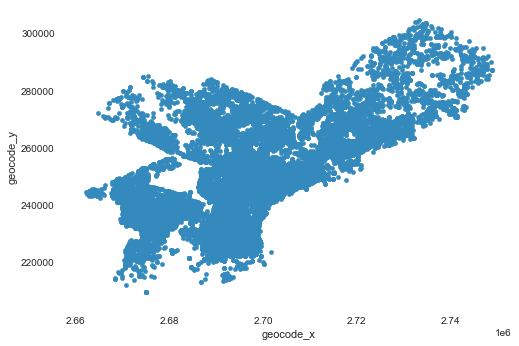

In [40]:
df.plot.scatter('geocode_x','geocode_y')

In [71]:
try:
    os.mkdir('images')
except:
    print('directory already exists')

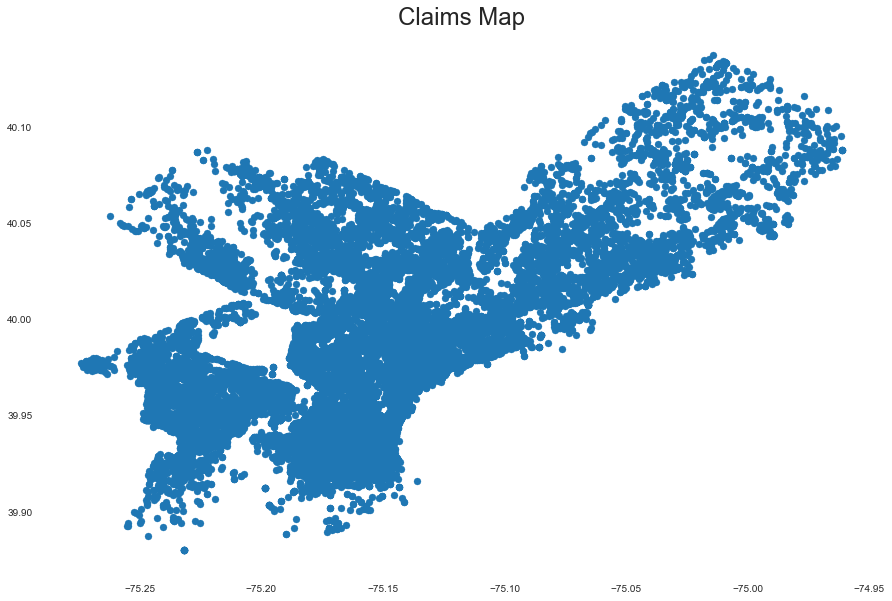

In [74]:
plt.figure(figsize=(15,10))
plt.title('Claims Map', size=24)
plt.rc('font', size=24)
plt.scatter(df['lng'], df['lat'])
plt.savefig('images/appeal_map.png',bbox_inches='tight')

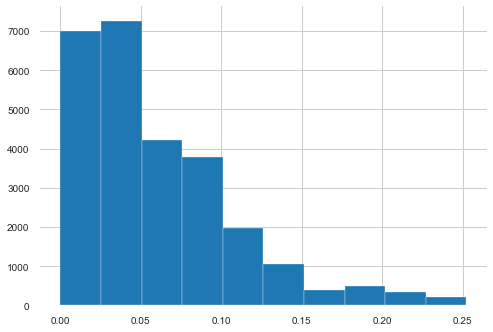

In [42]:
#Distance from CC
df['fromCC'].hist()

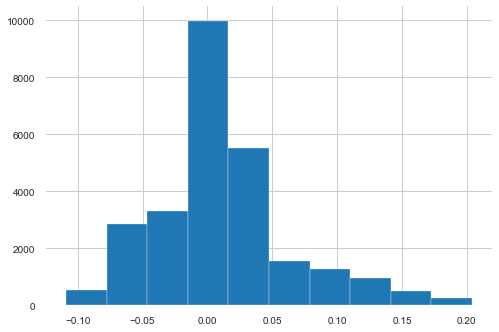

In [43]:
#Longtitude from CC
df['lngfromCC'].hist()

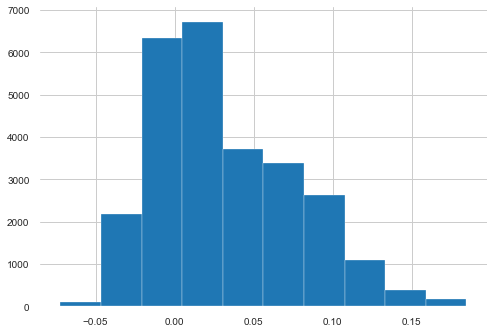

In [44]:
#Latitude from CC
df['latfromCC'].hist()

In [45]:
# Create metrics function to check metrics for different models

def metrics(model=None, features=None, X_test=None, y_true_test=None, X_train=None, y_true_train=None, \
            x_feature=None):
    
    hypertablerow={}
    hypertablerow['model']=model.__class__.__name__
    hypertablerow['features']=features
    hypertablerow['dropped isna columns']=True

    X_train_temp = X_train[features]
    X_test_temp = X_test[features]    
    model.fit(X_train_temp,y_train)
    
    y_pred_test = model.predict(X_test_temp)
    y_pred_train = model.predict(X_train_temp)


    hypertablerow['std_test'] = (y_true_test-y_pred_test).std()
    print('std_test', hypertablerow['std_test'])
    hypertablerow['std_train'] = (y_true_train - y_pred_train).std()
    print('std_train', hypertablerow['std_train'])
    hypertablerow['RMSE_test'] = math.sqrt(mean_squared_error(y_true=y_true_test, y_pred=y_pred_test))
    print('RMSE_test', hypertablerow['RMSE_test'])
    hypertablerow['RMSE_train']= math.sqrt(mean_squared_error(y_true=y_true_train, y_pred=y_pred_train))
    print('RMSE_train', hypertablerow['RMSE_train'])
    hypertablerow['training_score'] = model.score(X=X_train_temp, y=y_pred_train)
    print('training_score', hypertablerow['training_score'])
    hypertablerow['test_score'] = model.score(X=X_test_temp, y=y_pred_test)
    print('test_score', hypertablerow['test_score'])
    hypertable.append(hypertablerow)
    pd.Series(hypertablerow)
      
    return hypertablerow

In [46]:
# Create "dummy" variables for systemofrecord columns
df = pd.concat([df, pd.get_dummies(df['systemofrecord'])], axis=1)
df.columns

Index(['the_geom', 'the_geom_webmercator', 'objectid', 'addressobjectid',
       'address', 'unit_type', 'unit_num', 'zip', 'opa_account_num',
       'parcel_id_num', 'censustract', 'opa_owner', 'primaryappellant',
       'appellanttype', 'internaljobid', 'appealnumber', 'acceleratedappeal',
       'createddate', 'completeddate', 'relatedpermit', 'relatedcasefile',
       'appealstatus', 'appealtype', 'agendadescription', 'applicationtype',
       'meetingnumber', 'appealgrounds', 'scheduleddate', 'decision',
       'meetingresult', 'proviso', 'decisiondate', 'systemofrecord',
       'geocode_x', 'geocode_y', 'lat', 'lng', 'fromCC', 'latfromCC',
       'lngfromCC', 'ECLIPSE', 'HANSEN'],
      dtype='object')

In [47]:
# import the preprocessing package
from sklearn import preprocessing

# Declare an explanatory variable, and assign some data to it 
X = df[['ECLIPSE', 'HANSEN']]

# Declare a response variable, the decision column of the df 
y = df['decision'] 

In [48]:
# Get the 1-dimensional flattened array of our response variable y by calling the ravel() function on y
#y = y.ravel()

# Call the train_test_split() function
# Declare four variables, X_train, X_test, y_train and y_test separated by commas 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [49]:
y_train

22799       DISMISSED
10982    GRANTED/PROV
19391          DENIED
7803         AFFIRMED
26491    GRANTED/PROV
             ...     
11607         GRANTED
18306       WITHDRAWN
5430          GRANTED
12915       DISMISSED
246      GRANTED/PROV
Name: decision, Length: 20058, dtype: object

In [50]:
# Import svm model
from sklearn import svm

# Create a svm Classifier

clf = svm.SVC(kernel='linear') # Linear Kernel

# Train the model using the training sets
clf.fit(X_train, y_train)

# Predict ther response for test dataset
y_pred = clf.predict(X_test)

#features = X.columns
#hypertablerow = metrics(model=model, features=features, X_train=X_train, y_true_train=y_train, \
#                        X_test=X_test, y_true_test=y_test, x_feature='decision')

...

In [51]:
# Import metrics module
from sklearn import metrics

# Model Accuracy
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

print("Precision:", metrics.precision_score(y_test, y_pred, average = None))
#metrics.precision_score?

print("Recall:", metrics.recall_score(y_test, y_pred, average = None))


Accuracy: 0.33303424555106925
Precision: [0.         0.         0.         0.         0.         0.
 0.88888889 0.         0.         0.         0.         0.
 0.         0.32468124 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
Recall: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
X_train

,ECLIPSE,HANSEN
22799,0,1
10982,0,1
19391,0,1
7803,0,1
26491,0,1
...,...,...
11607,0,1
18306,0,1
5430,0,1
12915,0,1
